# Graph generation Notebook

The goal is to generate a dataset of synthetic graphs using different graph generation algorithms. We eill use specifically:
- Erdos-Renyi algorithm (specify nr. of nodes and probability to generate an edge)
- Random graphs (specify nr. of nodes and degrees of each node and the graph is sampled from an uniform distribution)

After the graphs have been ganarated we use an exact counting algorithm to geenrate the labels of the graphs.

In [12]:
# imports
import os
import time
import sys
import tqdm
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))

from networkx.generators import random_regular_graph, gnp_random_graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

from src.dataset.counting_algorithm import subgraph_counting, subgraph_counting_all

# set parameters
seed = 1 # seed for experiment reproducibility
n = 10 # number of nodes
p = 0.2 # probability of edge creation
d = 3 #degree of all the nodes

## Erdos-Renyi

Graph generation and visualization with Erdos-Renyi algorithm.

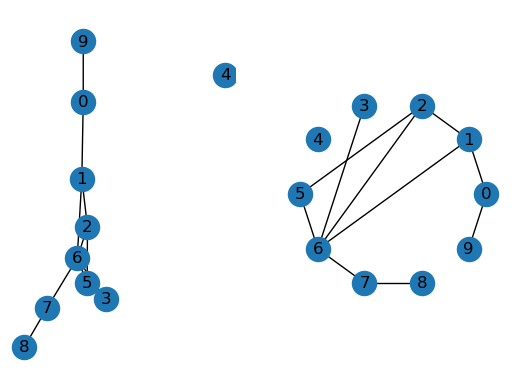

In [13]:
# remark: there is a faster algorithm for sparse graphs
kwargs = {'n':n, 'p':p, 'seed':None, 'directed':False}
random.seed(1)
gg = gnp_random_graph
er_graph = gg(**kwargs)
fig, ax = plt.subplots(1,2)
nx.draw(er_graph, with_labels=True, ax=ax[0])
ax[1].axis('equal')
nx.draw_circular(er_graph, with_labels = True, ax = ax[1])
plt.show(fig)


## Random Graphs

Graph generation and visualization with the regular Random Graph algorithm.

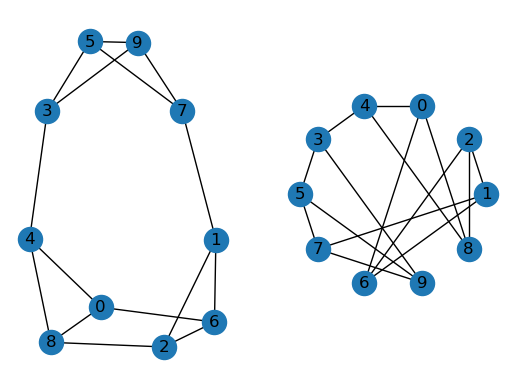

In [14]:
rg_graph = random_regular_graph(n=n, d=d, seed=seed)
fig, ax = plt.subplots(1,2)
nx.draw(rg_graph, with_labels=True, ax=ax[0])
ax[1].axis('equal')
nx.draw_circular(rg_graph, with_labels = True, ax = ax[1])
plt.show(fig)

In [15]:
import torch
import random
e = list(rg_graph.edges())
print(e[0])
e = torch.empty(2,rg_graph.number_of_edges())
for i, edge in enumerate(rg_graph.edges()):
    e[0,i] = edge[0]
e = np.array(list(nx.non_edges(rg_graph)), dtype=object)
print(e)
sampled = np.random.choice(np.array(range(len(e))), 5)
for i  in sampled:
    print(*e[i])

(1, 2)
[[0 1]
 [0 2]
 [0 3]
 [0 5]
 [0 7]
 [0 9]
 [1 3]
 [1 4]
 [1 5]
 [1 8]
 [1 9]
 [2 3]
 [2 4]
 [2 5]
 [2 7]
 [2 9]
 [3 8]
 [3 6]
 [3 7]
 [4 9]
 [4 5]
 [4 6]
 [4 7]
 [5 8]
 [5 6]
 [6 8]
 [6 9]
 [6 7]
 [7 8]
 [8 9]]
2 5
2 4
0 1
2 5
5 6


## Count the substructures

Try the algorithm to count the substructures of size 3 and 4

In [16]:

er_count = subgraph_counting(er_graph, '4-Cycle')
A = nx.to_numpy_array(er_graph)
A2=A.dot(A)
A3=A2.dot(A)
count=1/8*(np.trace(A3.dot(A))+np.trace(A2)-2*A2.sum())
print(er_count, count)
rg_counts = subgraph_counting_all(rg_graph)
print(f'Erdos_Renyi graph: \n{er_counts}')
print(f'Random graph: \n{rg_counts}')

0 1.0


NameError: name 'er_counts' is not defined

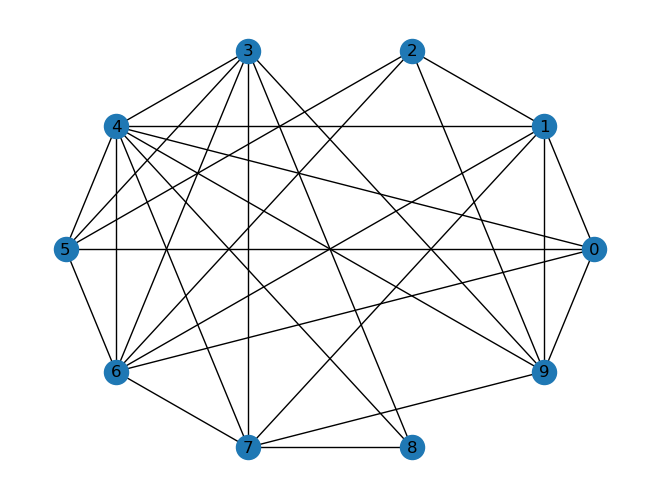

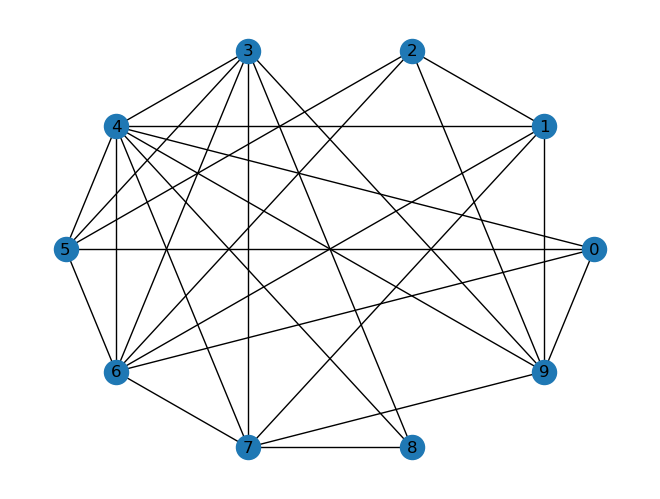

54


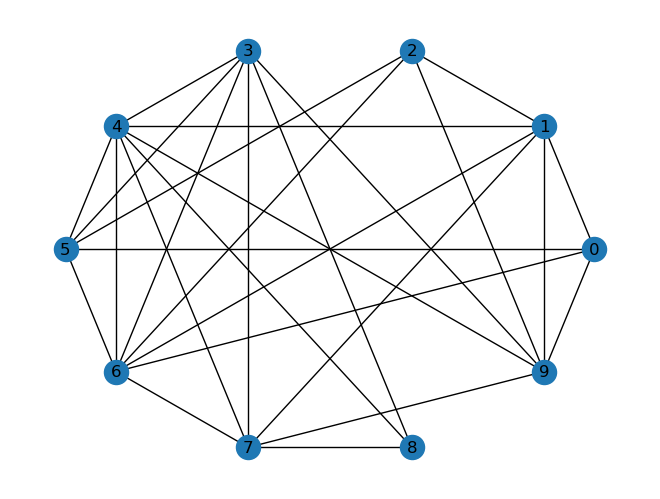

55


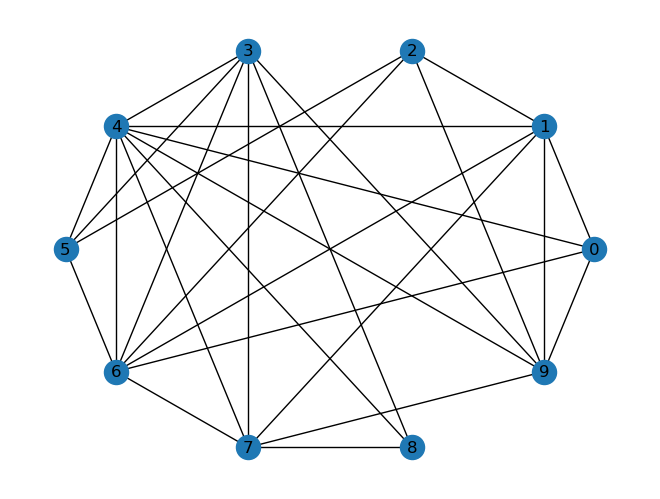

52


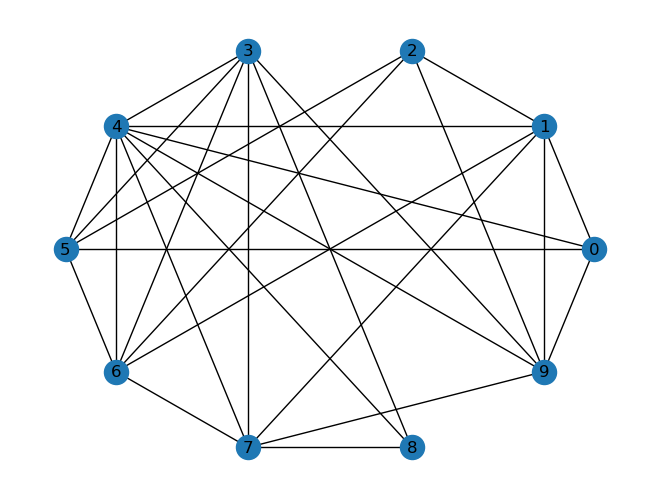

53


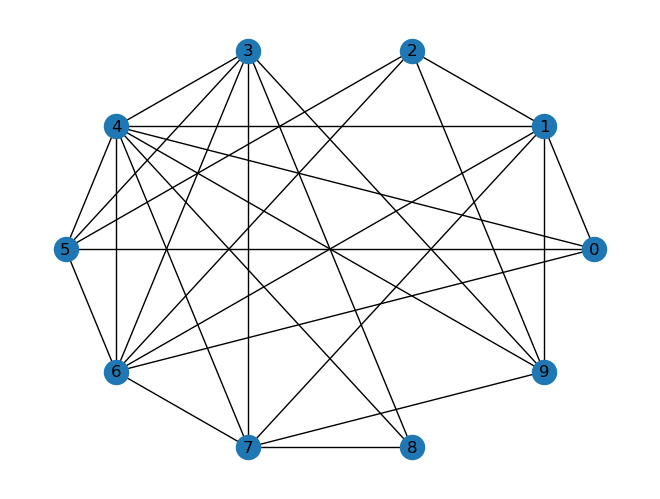

51


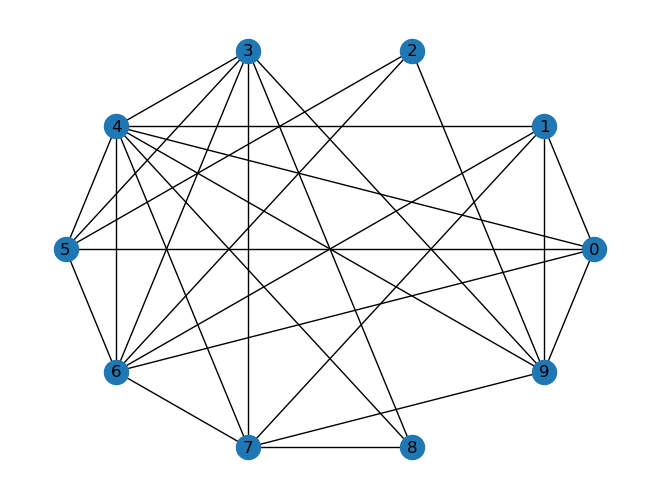

52


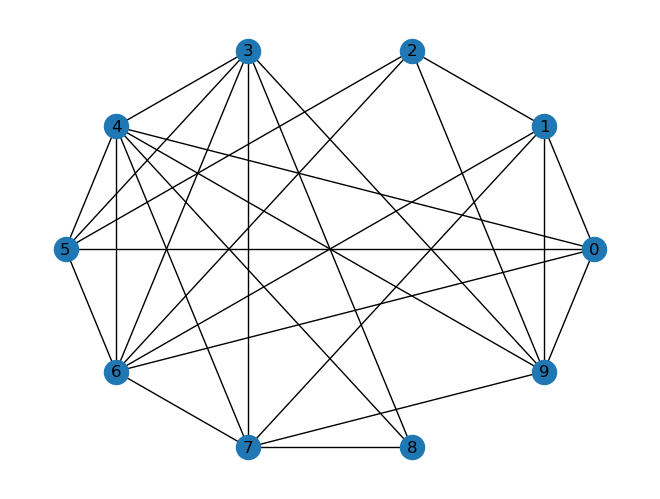

54


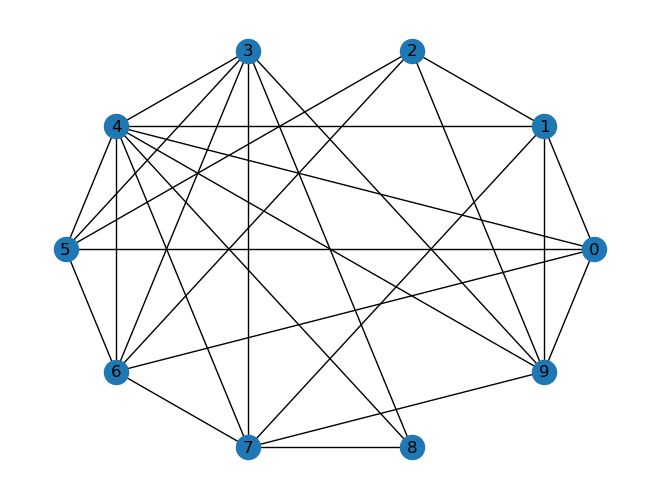

55


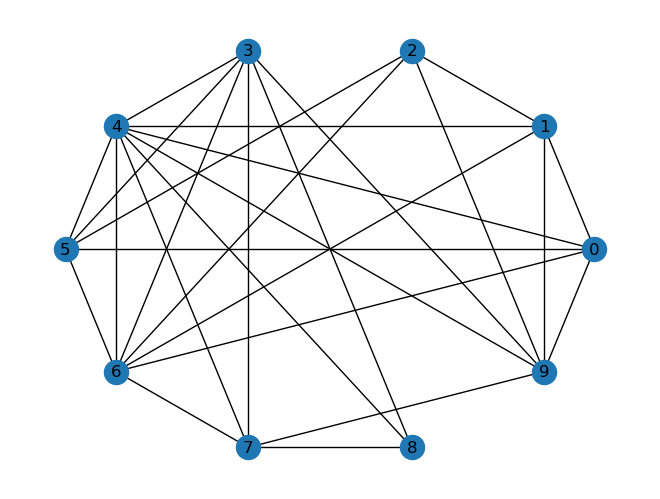

53


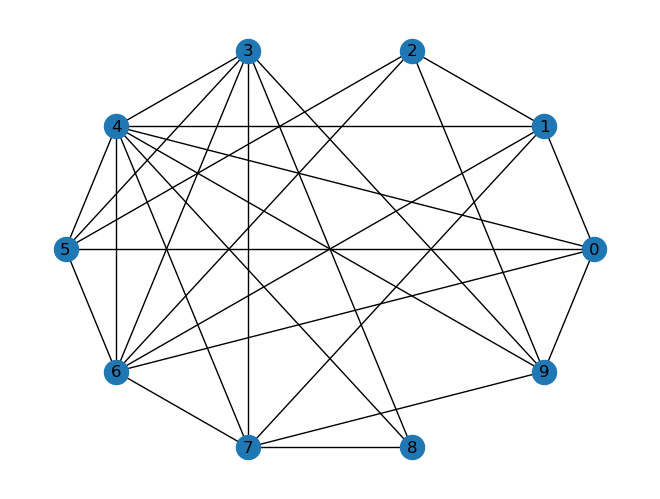

56


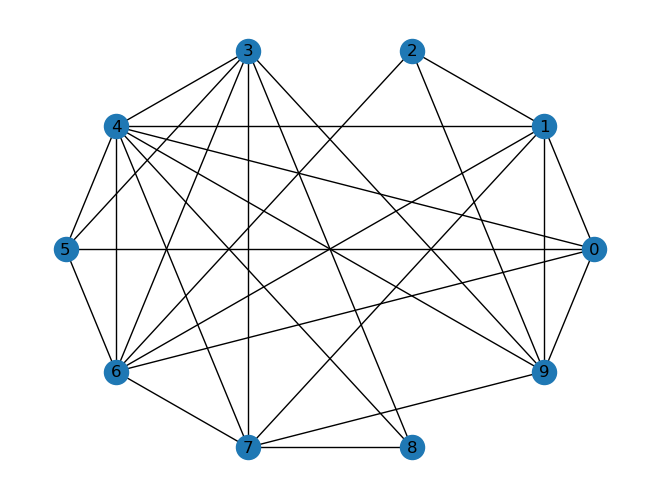

50


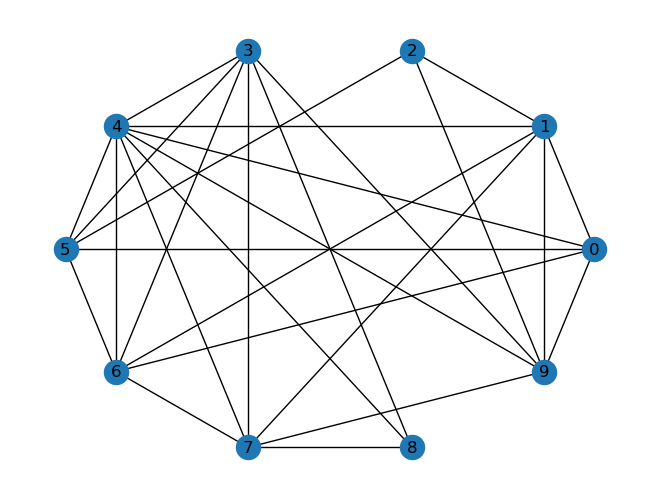

51


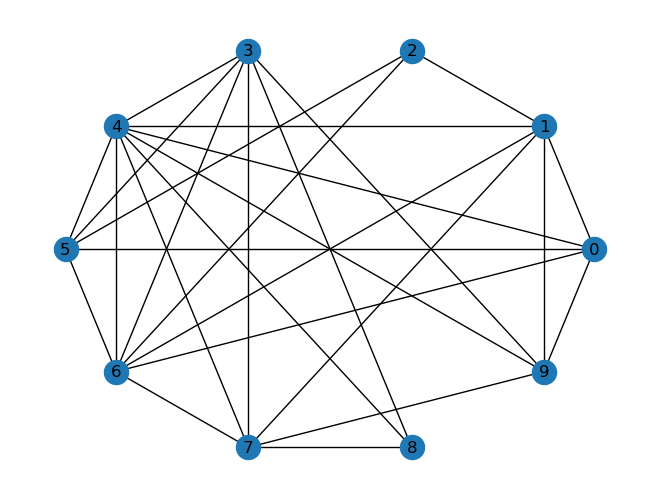

49


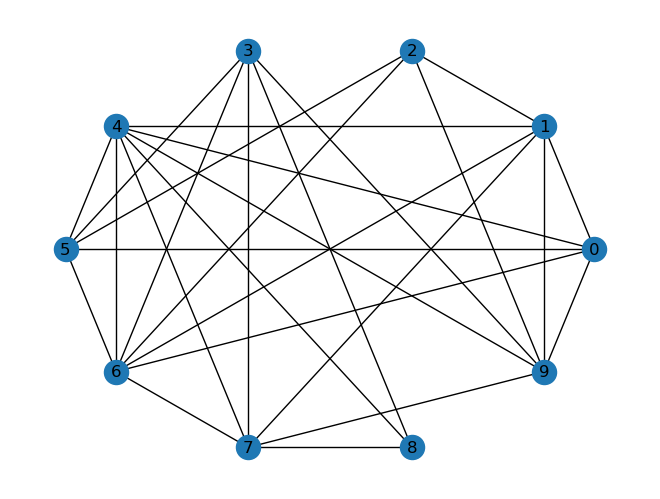

57


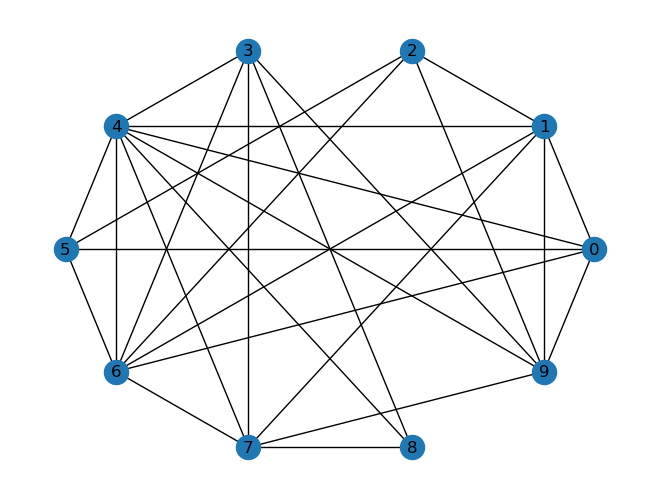

51


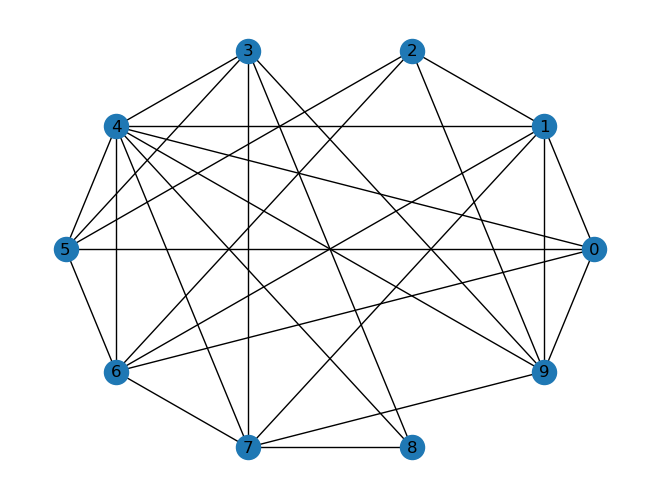

52


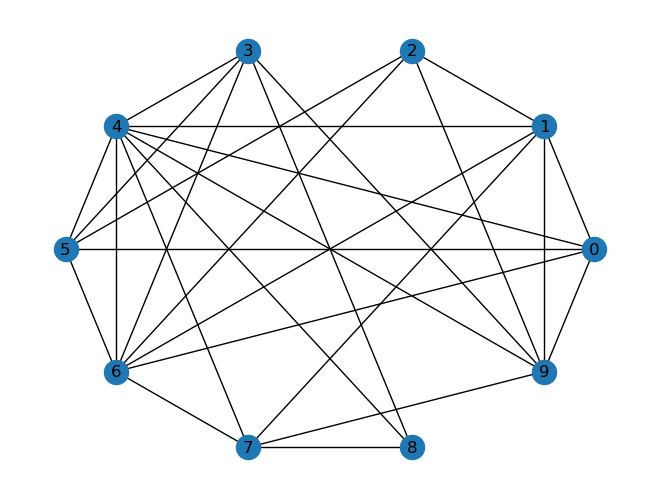

56


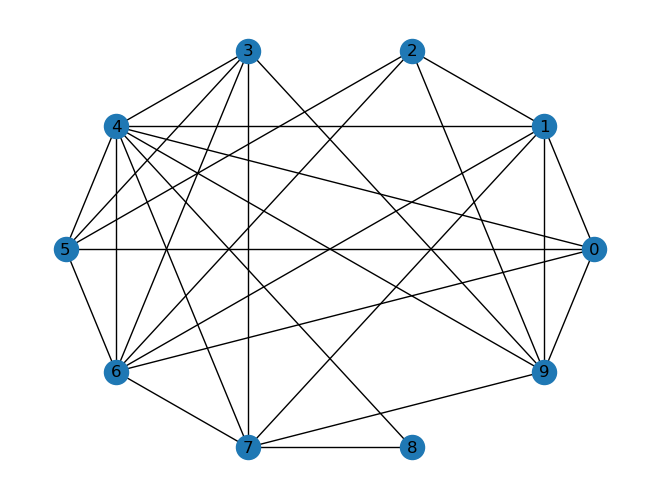

53


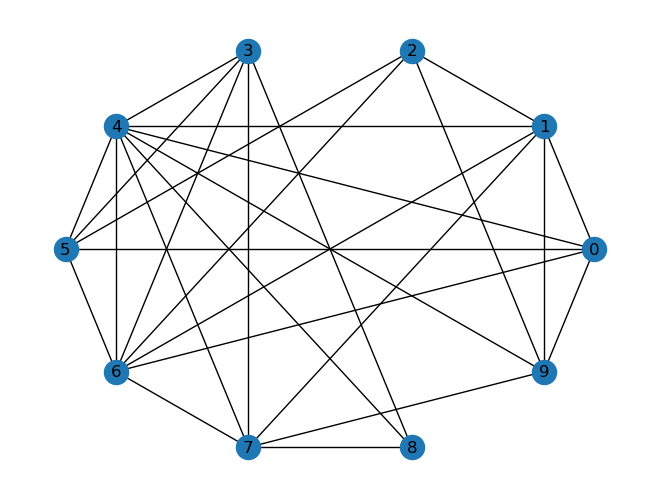

50


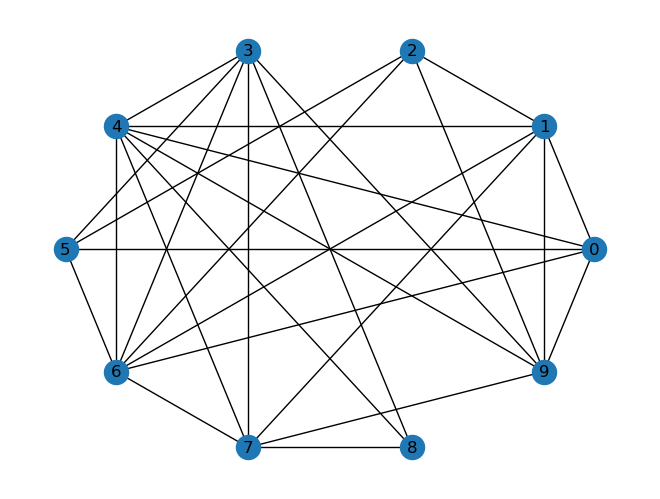

52


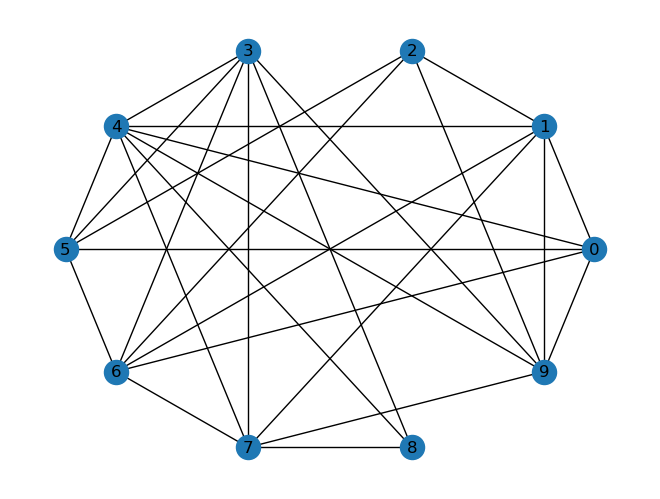

56


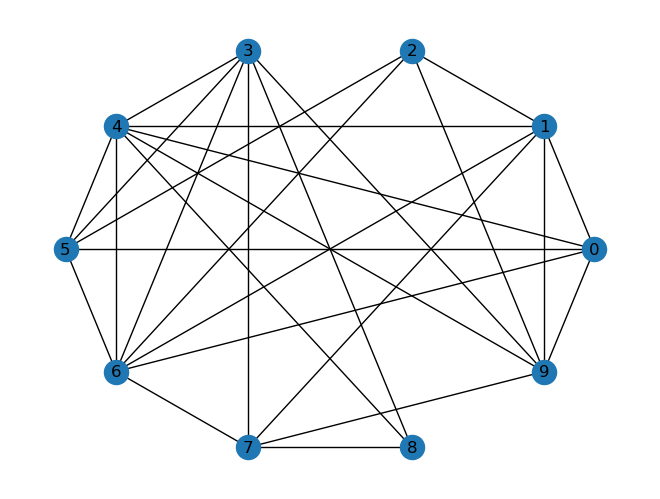

57


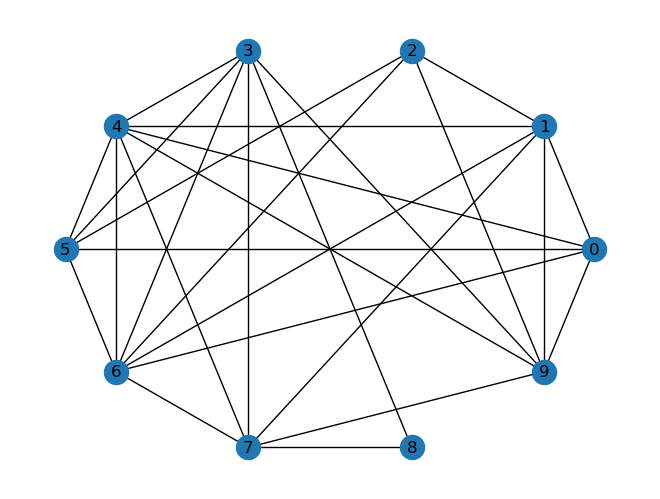

51


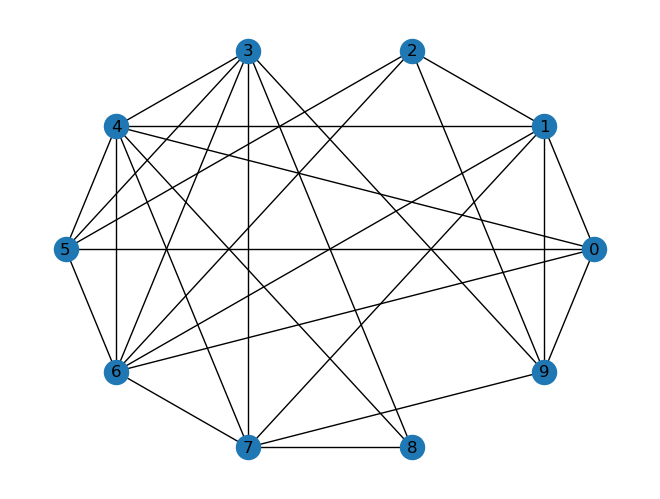

54


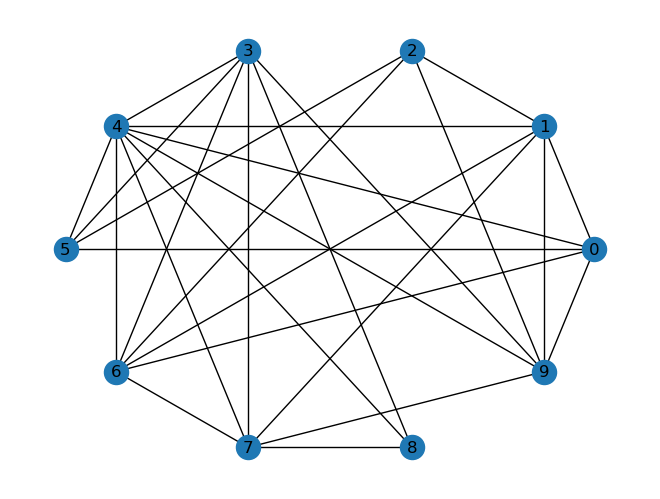

56


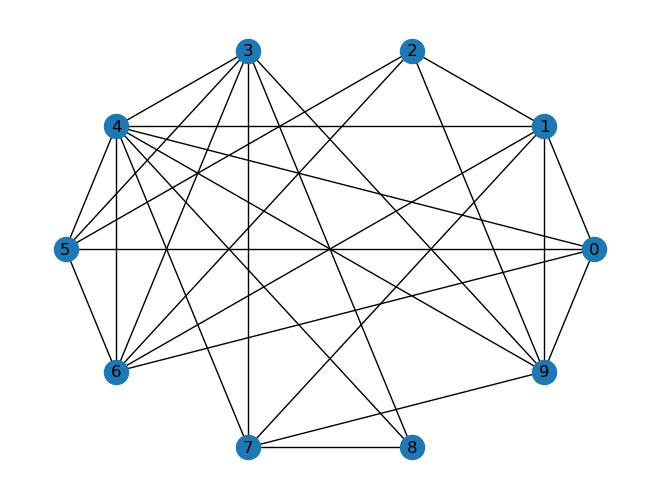

52


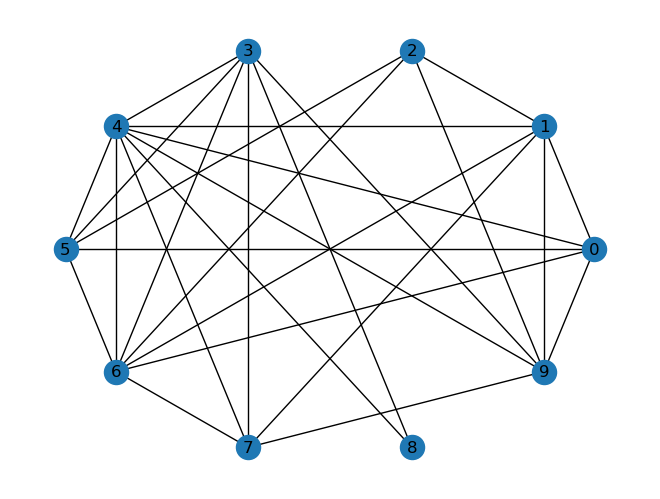

53


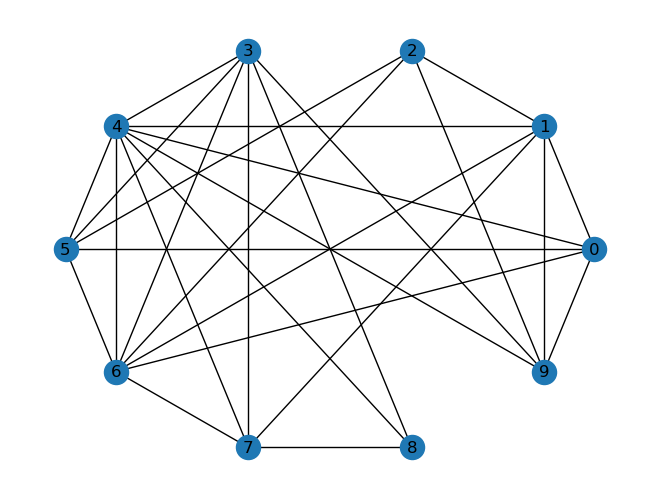

53


In [ ]:
diameters = {
    "g31": 2,
    "g32": 2,
    "g41": 1, 
    "g42": 2,
    "g43": 2,
    "g44": 2,
    "g45": 2,
    "g46": 3,
    "s3": 2,
}

def _generate_egonet(graph: nx.Graph, root: int, depth: int)->list[int]:
    """Generates an egonet of given depth starting from the root node"""
    # to generate the egonet we look for neighbours iteratively
    graph_copy = graph.copy()
    egonet = [root]
    neighbors = [root]
    visited = {root} # here we need to search for an element

    for i in range(depth):
        queue = neighbors
        neighbors = []
        for node in queue:
            for neighbor in graph_copy.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    neighbors.append(neighbor)
        if neighbors == []:
            break
        egonet.extend(neighbors)
    return egonet

def _edge_deletion(graph: nx.Graph, count: int, subgraph_type: str)->list[(nx.Graph, int)]:
    """Returns a list of all the possible perturbed graphs obtained by deleting one edge with the updated substructure counting.
    The substructure count for the perturbed graph is updated taking the egonet of 
    depth equal to the diameter of the substructure. In this case and edge is perturbed and one of the two end nodes of the 
    edge is used to generate the egonet, and the graph used is the  original because it generated the biggest egonet."""

    edge_deleted_graphs = []
    edges = nx.edges(graph)
    for edge in edges:
        perturbed_graph = graph.copy()
        perturbed_graph.remove_edge(*edge)
        # recompute the substructure coutns of the perturbed graph
        egonet = _generate_egonet(graph, edge[0], diameters[subgraph_type])
        #print(f"count: {count}")
        subgraph = graph.subgraph(egonet)
        subgraph_count = subgraph_counting(graph=subgraph, subgraph_type=subgraph_type)
        #print(f"subgraph count: {subgraph_count}")
        perturbed_subgraph = perturbed_graph.subgraph(egonet)
        perturbed_subgraph_count = subgraph_counting(graph=perturbed_subgraph, subgraph_type=subgraph_type)
        #print(f"perturbed subgraph count: {perturbed_subgraph_count}")
        perturbed_count = count + perturbed_subgraph_count - subgraph_count
        edge_deleted_graphs.append((perturbed_graph, perturbed_count))
    return edge_deleted_graphs

subgraph_type = 'g32'
graph = er_graph
count = er_counts[subgraph_type]
perturbed = _edge_deletion(graph, count, subgraph_type)
nx.draw_circular(graph, with_labels = True)
plt.show()
for graph, count in perturbed:
    nx.draw_circular(graph, with_labels = True)
    plt.show()
    print(count)
    assert count == subgraph_counting(graph, subgraph_type), f"true count: {subgraph_counting(graph, subgraph_type)}, coputed count: {count}"

## Evaluate the performances of the algorithm

To evaluate the performances we time how much time it takes to count the substructures in 100 graphs

In [ ]:
m = 1000
n = 200
p = 0.05
d = 10


graphs = []

for i in tqdm.tqdm(range(m)):
    #graphs.append(gnp_random_graph(n=n, p=p, seed=i, directed=False))
    graphs.append(random_regular_graph(n=n, d=d))

start = time.time()
for graph in tqdm.tqdm(graphs):
    count = egonet_del(graph, 0, 10)
print(f'Total time = {time.time() - start}')

  0%|          | 0/1000 [00:00<?, ?it/s]


NameError: name 'egonet_del' is not defined

# Solve problem or counts with an way easier model

see if the problem of substructure counting is somehow linear in some dimension:

**ANSWER:** it is not possible :)

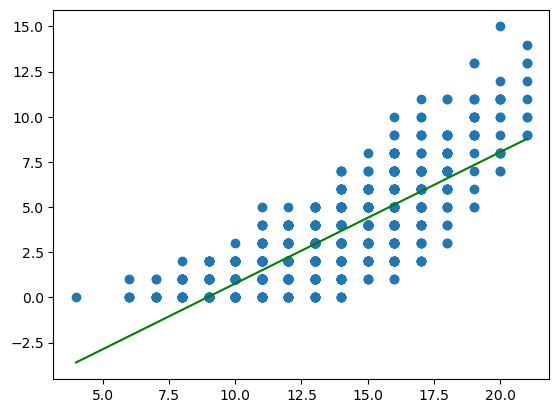

MSE of linear regression: 2.393724416867


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

m = 1000
n = 10
p = 0.3
motif_type = 'g31'

graphs = []
edges = np.zeros((m,1), dtype = int)
counts = np.zeros(m, dtype=int)
for i in range(m):
    graphs.append(gnp_random_graph(n=n, p=p, seed=i, directed=False))
    edges[i,0] = graphs[-1].number_of_edges()
    counts[i] = subgraph_counting(graphs[-1], motif_type)
plt.scatter(edges, counts)

reg = LinearRegression().fit(edges, counts)
x = np.array(list(range(np.min(edges), np.max(edges)+1)))
x = x.reshape(-1,1)
y = reg.predict(x)
plt.plot(x,y, color = 'g')
plt.show()

coutns_pred = reg.predict(edges)
print(f'MSE of linear regression: {mean_squared_error(counts, coutns_pred)}')

